The solution uses **Sentence-BERT (SBERT)**, a modification of the BERT architecture optimized for generating semantically meaningful embeddings that can be compared using cosine similarity. This approach is particularly well-suited for duplicate detection because:

1. **Semantic Understanding:** SBERT captures meaningful patterns beyond exact matching, handling variations in text and formatting and can learn domain-specific patterns of similarity from labeled examples
2. **Efficiency**: Using pre-trained language models with fine-tuning reduces training data requirements and computational costs.
3. **Precision Control:** The threshold selection approach enables precise control of the precision-recall tradeoff
4. **Explainability:** Similarity scores provide a measure of confidence, and the text-based approach allows for interpretation of what makes invoices similar.
5. **Scalability:** The approach of encoding documents once and comparing embeddings is more efficient than pairwise encoding.


### How It Works – Step-by-Step

#### 1. Setup & Load Data
Installs required libraries and enables GPU support for faster processing.

#### 2. Prepare Data for AI
- **Pair Creation:** Generates invoice pairs with rule based pre filtering ("blocking strategy") and labels them as duplicates or not based on the input.
- **Sentence Conversion:** Converts each invoice into a natural language sentence (e.g.,  
  *"Invoice from ACME Corp for $500 dated 2023-10-26"*) to make them suitable for SBERT input.

#### 3. Train SBERT Model
- Fine-tunes a pre-trained Sentence-BERT model on the labeled sentence pairs.
- The model learns to output high similarity scores for duplicates and low scores for non-duplicates.

#### 4. Determine Threshold
- Finds the optimal similarity threshold to classify duplicates with high precision.

#### 5. Evaluate Model
- Tests performance on unseen invoice pairs to validate accuracy and robustness.

#### 6. Package for Deployment
- Packages the fine-tuned model, threshold, and a script to apply it to new invoice data.
- Includes basic tests for the final script to ensure reliability.

# 0. Setup and Dependencies

###Change train_dataloader batch_size to 520 for big dataset or 8 with small:

```
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=8, #Adjust with dataset size
    drop_last=True
)
```



###Use GPU else you get error!

In [1]:
# Install required packages
!pip install -q transformers sklearn tqdm
!pip install -U sentence-transformers
!pip install datasets
!pip install tensorflow
!pip install scikit-learn
!pip install fuzzywuzzy python-Levenshtein

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Set and validate that CuDF can use the CUDA-capable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Gives CuDF access to Google Colab GPU
print(os.environ.get('CUDA_VISIBLE_DEVICES'))

0


In [1]:
# Set environment variables for reproducibility
import os
os.environ['PYTHONHASHSEED'] = '42'

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import itertools
import random
from datetime import datetime
from sentence_transformers import SentenceTransformer, InputExample, losses, SentencesDataset
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import gc
import re
from tqdm.notebook import tqdm
import json

# Set global random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.6.0+cu124


# 1. Data Preperation

- The coerce parameter in conversion functions replaces invalid values with NaN rather than raising errors
- Using format='mixed' handles diverse date formats, important in real-world financial data
- Sorting creates a deterministic order, which is crucial for reproducibility in machine learning experiments

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Data ingestion
file_path = '/content/drive/MyDrive/payguardml/Adjusted_Improved_Realistic_Invoice_Dataset.csv'

# Read all objects as string
df = pd.read_csv(file_path, dtype=str, sep=";")

# Convert numeric and date columns to appropriate types
df['AMOUNT'] = pd.to_numeric(df['AMOUNT'], errors='coerce')

# Convert date columns with flexible parsing
df['INVOICE_DATE'] = pd.to_datetime(df['INVOICE_DATE'], errors='coerce', format='mixed')

# Sort by DOC_NO for deterministic row order
df = df.sort_values("DOC_NO").reset_index(drop=True)

# Display information about the dataset
print(f"Dataset shape: {df.shape}")
print(df.dtypes)
df.head()

Mounted at /content/drive
Dataset shape: (1320, 13)
DOC_NO                    object
DUP_OF_DOC_ID             object
VENDOR_NAME               object
VENDOR_ID                 object
AMOUNT                   float64
CURRENCY                  object
INVOICE_DATE      datetime64[ns]
DESCRIPTION               object
PURCHASE_ORDER            object
COMPANY_CODE              object
COST_CENTER               object
TAX_CODE                  object
PAYMENT_TERMS             object
dtype: object


,DOC_NO,DUP_OF_DOC_ID,VENDOR_NAME,VENDOR_ID,AMOUNT,CURRENCY,INVOICE_DATE,DESCRIPTION,PURCHASE_ORDER,COMPANY_CODE,COST_CENTER,TAX_CODE,PAYMENT_TERMS
0,3000000000,NaN,Wonka Inc.,86623,31074.96,GBP,2023-05-29,Marketing campaign,PO5494,1000,200608,VA,NET45
1,3000000001,NaN,Vehement Inc.,21937,23585.85,CHF,2023-05-24,Data migration,PO6381,2000,243182,NP,NET30
2,3000000002,NaN,Gringotts LLC,46650,42482.90,USD,2022-04-05,Business strategy,PO8055,2000,292509,VA,NET45
3,3000000003,NaN,LexCorp Ltd.,60778,11477.07,CHF,2023-03-31,Business strategy,PO1841,1000,250485,VA,NET60
4,3000000004,NaN,Oscorp GmbH,73693,39469.94,GBP,2023-02-16,Cloud hosting,PO6655,3000,249122,NP,NET60


# 2. Pair Generation

In [3]:
def generate_pairs_with_blocking(df, batch_size=250000, neg_pos_ratio=5):
    """
    Generate pairs of invoices with blocking strategy.

    Uses multiple independent blocking criteria (only one needs to match):
    - Same VENDOR_ID
    - Same first 4 chars of VENDOR_NAME
    - Same PURCHASE_ORDER
    - Same DESCRIPTION
    - Same Amount and currency

    Args:
        df: DataFrame containing invoice data
        batch_size: Number of pairs to process in each batch
        neg_pos_ratio: Ratio of negative to positive examples

    Returns:
        DataFrame of pairs with labels
    """
    import pandas as pd
    from tqdm import tqdm
    import gc

    N = len(df)
    print(f"Generating pairs for {N} invoices with relaxed blocking strategy...")

    # First, analyze duplicates in the dataset
    print("\nAnalyzing duplicates in the dataset:")
    dup_counts = df['DUP_OF_DOC_ID'].notna() & (df['DUP_OF_DOC_ID'] != '')
    print(f"Number of invoices marked as duplicates: {dup_counts.sum()}")

    if dup_counts.sum() > 0:
        # Sample of duplicate entries
        print("\nSample entries with DUP_OF_DOC_ID:")
        dup_sample = df[dup_counts].head(3)
        for _, row in dup_sample.iterrows():
            print(f"DOC_NO: {row['DOC_NO']}, DUP_OF_DOC_ID: {row['DUP_OF_DOC_ID']}")

    # Create a map of DOC_NO to index for faster lookups
    doc_no_to_idx = {doc_no: idx for idx, doc_no in enumerate(df['DOC_NO'])}

    # Create a lookup for duplicate relationships
    duplicate_map = {}

    for idx, row in df.iterrows():
        if pd.notna(row['DUP_OF_DOC_ID']) and row['DUP_OF_DOC_ID'] != '':
            dup_doc_id = row['DUP_OF_DOC_ID']
            duplicate_map[row['DOC_NO']] = dup_doc_id

    print(f"\nCreated duplicate map with {len(duplicate_map)} entries")

    # Create pairs for known duplicates first
    known_duplicate_pairs = []

    for doc_no, dup_doc_id in duplicate_map.items():
        # Check if the duplicate doc_id exists in our dataframe
        if dup_doc_id in doc_no_to_idx:
            idx1 = doc_no_to_idx[doc_no]
            idx2 = doc_no_to_idx[dup_doc_id]
            known_duplicate_pairs.append((min(idx1, idx2), max(idx1, idx2)))

    print(f"Found {len(known_duplicate_pairs)} known duplicate pairs where both invoices are in the dataset")

    # Apply blocking to create index pairs that potentially match
    candidate_pairs = set()  # Using a set to avoid duplicates

    total_possible_pairs = N * (N - 1) // 2
    print(f"Total possible pairs without blocking: {total_possible_pairs}")

    # 1. BLOCKING BY VENDOR_ID
    vendor_groups = df.groupby('VENDOR_ID').indices
    for vendor_id, indices in vendor_groups.items():
        if len(indices) < 2:
            continue

        # Add all pairs within this vendor group
        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    # 2. BLOCKING BY VENDOR_NAME PREFIX (first 4 chars)
    vendor_name_prefix_groups = {}
    for idx, vendor_name in enumerate(df['VENDOR_NAME']):
        if pd.isna(vendor_name) or vendor_name == '':
            continue

        prefix = str(vendor_name)[:4] if len(str(vendor_name)) >= 4 else str(vendor_name)
        if prefix not in vendor_name_prefix_groups:
            vendor_name_prefix_groups[prefix] = []
        vendor_name_prefix_groups[prefix].append(idx)

    for prefix, indices in vendor_name_prefix_groups.items():
        if len(indices) < 2:
            continue

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    # 3. BLOCKING BY PURCHASE_ORDER
    po_groups = df.groupby('PURCHASE_ORDER').indices
    for po, indices in po_groups.items():
        if pd.isna(po) or po == '' or len(indices) < 2:
            continue

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    # 4. BLOCKING BY DESCRIPTION
    desc_groups = df.groupby('DESCRIPTION').indices
    for desc, indices in desc_groups.items():
        if pd.isna(desc) or desc == '' or len(indices) < 2:
            continue

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    # 5. BLOCKING BY AMOUNT AND CURRENCY
    amount_currency_groups = df.groupby(['AMOUNT', 'CURRENCY']).indices
    for (amount, currency), indices in amount_currency_groups.items():
        if pd.isna(amount) or pd.isna(currency) or len(indices) < 2:
            continue

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    # Add all known duplicate pairs to ensure they're included
    for pair in known_duplicate_pairs:
        candidate_pairs.add(pair)

    # Convert set to list for easier processing
    candidate_pairs = list(candidate_pairs)

    print(f"Generated {len(candidate_pairs)} candidate pairs after blocking")
    print(f"Reduction: {1 - len(candidate_pairs)/total_possible_pairs:.2%} of pairs filtered out")

    # Print information about the candidate pairs
    print("\nSample of 10 candidate pairs after blocking (sorted by VENDOR_ID):")
    candidate_df_rows = []

    for idx1, idx2 in candidate_pairs:
        doc1, doc2 = df.iloc[idx1], df.iloc[idx2]

        # Check if this is a known duplicate pair
        is_duplicate = False
        if doc1['DOC_NO'] in duplicate_map and duplicate_map[doc1['DOC_NO']] == doc2['DOC_NO']:
            is_duplicate = True
        elif doc2['DOC_NO'] in duplicate_map and duplicate_map[doc2['DOC_NO']] == doc1['DOC_NO']:
            is_duplicate = True

        candidate_df_rows.append({
            'VENDOR_ID': doc1['VENDOR_ID'],
            'DOC_NO_1': doc1['DOC_NO'],
            'DOC_NO_2': doc2['DOC_NO'],
            'AMOUNT_1': doc1['AMOUNT'],
            'AMOUNT_2': doc2['AMOUNT'],
            'CURRENCY_1': doc1['CURRENCY'],
            'CURRENCY_2': doc2['CURRENCY'],
            'DATE_1': doc1['INVOICE_DATE'],
            'DATE_2': doc2['INVOICE_DATE'],
            'IS_DUPLICATE': is_duplicate
        })

    # Create a dataframe of the candidate pairs for easier viewing
    if candidate_df_rows:
        candidate_df = pd.DataFrame(candidate_df_rows)
        # Sort by VENDOR_ID
        candidate_df = candidate_df.sort_values('VENDOR_ID')
        print(candidate_df.head(10).to_string())

        # Check for duplicates in the candidate pairs
        duplicate_pairs = candidate_df[candidate_df['IS_DUPLICATE'] == True]
        print(f"\nFound {len(duplicate_pairs)} known duplicate pairs in candidate pairs")

        if not duplicate_pairs.empty:
            print("\nSample of known duplicate pairs:")
            print(duplicate_pairs.head(5).to_string())
    else:
        print("No candidate pairs to display")

    # Initialize batches for processing
    pair_dfs = []
    current_batch = []
    positive_count = 0
    negative_count = 0

    # Process pairs
    for idx1, idx2 in tqdm(candidate_pairs):
        doc1, doc2 = df.iloc[idx1], df.iloc[idx2]

        # Correctly determine if the pair is a duplicate
        is_duplicate = False
        if doc1['DOC_NO'] in duplicate_map and duplicate_map[doc1['DOC_NO']] == doc2['DOC_NO']:
            is_duplicate = True
        elif doc2['DOC_NO'] in duplicate_map and duplicate_map[doc2['DOC_NO']] == doc1['DOC_NO']:
            is_duplicate = True

        # Always include positive pairs
        if is_duplicate:
            positive_count += 1
            label = 1
            current_batch.append((idx1, idx2, label))
        else:
            # Include negative pairs based on the ratio
            if negative_count < positive_count * neg_pos_ratio or positive_count == 0:
                # If no positives yet, include some negatives anyway
                if len(current_batch) < batch_size:
                    negative_count += 1
                    label = 0
                    current_batch.append((idx1, idx2, label))

        # Process batch when it reaches the desired size
        if len(current_batch) >= batch_size:
            batch_df = create_pair_dataframe(df, current_batch)
            pair_dfs.append(batch_df)
            current_batch = []

            # Free memory
            gc.collect()

    # Process remaining pairs
    if current_batch:
        batch_df = create_pair_dataframe(df, current_batch)
        pair_dfs.append(batch_df)

    # Combine all batches
    final_pairs_df = pd.concat(pair_dfs, ignore_index=True) if pair_dfs else pd.DataFrame()
    print(f"\nFinal pairs dataframe shape: {final_pairs_df.shape}")
    print(f"Positive pairs: {positive_count}, Negative pairs: {negative_count}")

    return final_pairs_df

def create_pair_dataframe(df, pairs):
    """
    Create a dataframe from a list of pairs.

    Args:
        df: Original dataframe
        pairs: List of tuples (idx1, idx2, label)

    Returns:
        DataFrame with pairs
    """
    records = []

    for idx1, idx2, label in pairs:
        record = {}

        # Add columns for first invoice with prefix INV1_
        for col in df.columns:
            record[f'INV1_{col}'] = df.iloc[idx1][col]

        # Add columns for second invoice with prefix INV2_
        for col in df.columns:
            record[f'INV2_{col}'] = df.iloc[idx2][col]

        # Add label
        record['LABEL'] = label

        records.append(record)

    return pd.DataFrame(records)

# Generate pairs
pairs_df = generate_pairs_with_blocking(df)

# Save pairs to parquet file
pairs_df.to_parquet('/content/invoice_pairs.parquet', index=False)

Generating pairs for 1320 invoices with relaxed blocking strategy...

Analyzing duplicates in the dataset:
Number of invoices marked as duplicates: 240

Sample entries with DUP_OF_DOC_ID:
DOC_NO: 3000000005, DUP_OF_DOC_ID: 3000000006
DOC_NO: 3000000006, DUP_OF_DOC_ID: 3000000005
DOC_NO: 3000000014, DUP_OF_DOC_ID: 3000000015

Created duplicate map with 240 entries
Found 240 known duplicate pairs where both invoices are in the dataset
Total possible pairs without blocking: 870540
Generated 130624 candidate pairs after blocking
Reduction: 85.00% of pairs filtered out

Sample of 10 candidate pairs after blocking (sorted by VENDOR_ID):
       VENDOR_ID    DOC_NO_1    DOC_NO_2  AMOUNT_1  AMOUNT_2 CURRENCY_1 CURRENCY_2     DATE_1     DATE_2  IS_DUPLICATE
47789      19970  3000000300  3000000477  36349.99  28405.21        USD        GBP 2022-07-14 2023-03-31         False
12107      19970  3000000390  3000000652  46223.28   1395.18        USD        GBP 2023-03-17 2022-10-19         False
5698

100%|██████████| 130624/130624 [00:18<00:00, 6985.84it/s]



Final pairs dataframe shape: (720, 27)
Positive pairs: 120, Negative pairs: 600


# 3. Row to Sentence Conversion

- The template approach bridges structured data and natural language understanding
- Including critical invoice attributes (vendor, amount, date) in a consistent format helps the model distinguish important features
- Handling missing values with placeholders ("unknown") maintains consistent sentence structure

In [4]:
def row_to_sentence(row):
    """
    Convert a row to a sentence using a deterministic template.

    Args:
        row: DataFrame row

    Returns:
        String sentence representation
    """
    # Handle missing values
    vendor_name = row['VENDOR_NAME'] if not pd.isna(row['VENDOR_NAME']) and row['VENDOR_NAME'] != '' else "unknown"
    vendor_id = row['VENDOR_ID'] if not pd.isna(row['VENDOR_ID']) and row['VENDOR_ID'] != '' else "unknown"

    # Format invoice date
    try:
        invoice_date = row['INVOICE_DATE'].strftime('%Y-%m-%d') if not pd.isna(row['INVOICE_DATE']) else "unknown"
    except:
        invoice_date = "unknown"

    # Format amount
    try:
        amount = f"{float(row['AMOUNT']):.2f}" if not pd.isna(row['AMOUNT']) else "unknown"
    except:
        amount = "unknown"

    currency = row['CURRENCY'] if not pd.isna(row['CURRENCY']) and row['CURRENCY'] != '' else "unknown"
    cost_center = row['COST_CENTER'] if not pd.isna(row['COST_CENTER']) and row['COST_CENTER'] != '' else "unknown"
    tax_code = row['TAX_CODE'] if not pd.isna(row['TAX_CODE']) and row['TAX_CODE'] != '' else "unknown"
    payment_terms = row['PAYMENT_TERMS'] if not pd.isna(row['PAYMENT_TERMS']) and row['PAYMENT_TERMS'] != '' else "unknown"
    purchase_order = row['PURCHASE_ORDER'] if not pd.isna(row['PURCHASE_ORDER']) and row['PURCHASE_ORDER'] != '' else "unknown"
    description = row['DESCRIPTION'] if not pd.isna(row['DESCRIPTION']) and row['DESCRIPTION'] != '' else "unknown"

    # Combine into template
    template = (
      f"Invoice from {vendor_name} ({vendor_id}) "
      f"dated {invoice_date} for {amount} {currency}. "
      f"PO: {purchase_order}. Cost centre {cost_center}. Tax {tax_code}. Terms {payment_terms}. "
      f"Description: {description}."
  )

    return template

# Create sentence cache
# this is a performance optimization. The sentence cache prevents redundant text processing and conversion during training and evaluation.
sentence_cache = {}
for idx, row in tqdm(df.iterrows(), total=len(df)):
    doc_no = row['DOC_NO']
    sentence = row_to_sentence(row)
    sentence_cache[doc_no] = sentence

# Save sentence cache for later use
with open('/content/sentence_cache.json', 'w') as f:
    json.dump(sentence_cache, f)

print(f"Created {len(sentence_cache)} cached sentences")

  0%|          | 0/1320 [00:00<?, ?it/s]

Created 1320 cached sentences


# 4. Training and Validation Split

In [7]:
# Split train_pairs into train and validation (80/20 split, stratified by LABEL)
train_pairs, val_pairs = train_test_split(
    pairs_df,
    test_size=0.2,
    random_state=SEED,
    stratify=pairs_df['LABEL']
)

print(f"Training pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")

# Reset indices
train_pairs = train_pairs.reset_index(drop=True)
val_pairs = val_pairs.reset_index(drop=True)

# Save train and validation sets
train_pairs.to_parquet('/content/train_pairs.parquet', index=False)
val_pairs.to_parquet('/content/val_pairs.parquet', index=False)
val_pairs.to_csv('/content/val_pairs.csv', index=False)

Training pairs: 576
Validation pairs: 144


# 5. Model Definition

**Model Architecture Selection:**
- The all-MiniLM-L6-v2 model is a distilled version of BERT, optimized for sentence embedding tasks
- It has 6 layers instead of BERT's 12 layers, making it faster and less resource-intensive
- It produces 384-dimensional embeddings that capture semantic meaning
- This model was pre-trained on multiple tasks including natural language inference and semantic textual similarity
- Using a pre-trained model leverages transfer learning, crucial when labeled data is limited

**Training Procedure:**

- The InputExample format explicitly represents the pairwise relationship for contrastive learning
- Using a learning rate of 1e-5 with AdamW optimizer follows best practices for fine-tuning transformer models
- The relatively small number of epochs (4) is common when fine-tuning pre-trained transformers


**Contrastive loss** is particularly suitable for duplicate detection as it:
- Minimizes distance between duplicate pairs (positive examples)
- Maximizes distance between non-duplicate pairs (negative examples)
- Uses a margin parameter (0.5) that enforces a minimum separation between classes
- This creates a representation space where similar invoices cluster together
- It's an example of metric learning, which learns distance functions directly from data

In [7]:
# Initialize the SBERT model
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Move model to GPU
model = model.to(device)
print(f"Model loaded on {device}")

# Create training examples
train_examples = []
for _, row in tqdm(train_pairs.iterrows(), total=len(train_pairs)):
    doc_no1 = row['INV1_DOC_NO']
    doc_no2 = row['INV2_DOC_NO']

    # Get cached sentences
    s1 = sentence_cache[doc_no1]
    s2 = sentence_cache[doc_no2]

    # Create input example
    example = InputExample(texts=[s1, s2], label=float(row['LABEL']))
    train_examples.append(example)

# Set up training parameters
train_dataset = SentencesDataset(train_examples, model)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=8,
    drop_last=False,
    collate_fn=model.smart_batching_collate
)

# Define loss function
loss = losses.ContrastiveLoss(model=model, margin=0.5)

# Set up optimizer and scheduler
num_epochs = 4
train_steps = len(train_dataloader) * num_epochs
warmup_steps = int(train_steps * 0.1)  # 10% of total steps

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Define a custom callback function for logging
class LoggingCallback:
    def __init__(self, log_every=100):
        self.log_every = log_every
        self.step = 0

    def __call__(self, score, epoch, steps):
        self.step += 1
        if self.step % self.log_every == 0:
            print(f"Epoch: {epoch}, Step: {self.step}, Loss: {score}")

logging_callback = LoggingCallback(log_every=100)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model loaded on cuda


  0%|          | 0/576 [00:00<?, ?it/s]

# 6. Training Procedure

In [8]:
# Disable wandb logging
import os
os.environ["WANDB_DISABLED"] = "true"

# Check if our dataset is empty
print(f"Number of training examples: {len(train_examples)}")
print(f"Number of batches: {len(train_dataloader)}")

if len(train_examples) == 0:
    raise ValueError("Training dataset is empty. Please check dataset creation.")

Number of training examples: 576
Number of batches: 72


In [9]:
# Train the model
print(f"Starting training for {num_epochs} epochs...")

model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    scheduler='WarmupLinear',
    warmup_steps=warmup_steps,
    evaluation_steps=0,
    output_path=None,
    callback=logging_callback,
    show_progress_bar=True,
    use_amp=False
)

# Save the trained model
output_dir = '/content/invoice_sbert'
model.save(output_dir)
print(f"Model saved to {output_dir}")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting training for 4 epochs...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Model saved to /content/invoice_sbert


# 7. Threshold Selection


**Decision threshold**, commonly used in models that output scores or probabilities. It determines the trade-off between recall and precision.
- Low threshold → high recall, low precision (many false positives).
- High threshold → high precision, low recall (many false negatives).

-----

- Setting a minimum precision of 90% prioritizes precision over recall, appropriate for financial applications where false positives are costlier than false negatives
- Optimizing F1 score (harmonic mean of precision and recall) among high-precision thresholds balances the tradeoff
- The approach is similar to Neyman-Pearson lemma in statistical hypothesis testing, which fixes one error type and minimizes the other
- Using validation data for threshold selection prevents overfitting to the training data

In [10]:
def compute_similarities(model, val_pairs, sentence_cache):
    """
    Compute cosine similarities for validation pairs

    Args:
        model: Trained SBERT model
        val_pairs: Validation pairs dataframe
        sentence_cache: Dictionary of cached sentences

    Returns:
        Tuple of (similarities array, true labels array)
    """
    # Get unique document IDs in validation set
    doc_nos = set()
    for _, row in val_pairs.iterrows():
        doc_nos.add(row['INV1_DOC_NO'])
        doc_nos.add(row['INV2_DOC_NO'])

    # Create a batch of sentences to embed
    doc_no_to_idx = {}
    sentences = []
    for i, doc_no in enumerate(doc_nos):
        doc_no_to_idx[doc_no] = i
        sentences.append(sentence_cache[doc_no])

    # Encode all sentences at once
    print(f"Encoding {len(sentences)} unique sentences...")
    embeddings = model.encode(sentences, convert_to_tensor=True, device=device)
    embeddings = embeddings.cpu().numpy()

    # Compute similarities for all pairs
    similarities = []
    labels = []

    for _, row in tqdm(val_pairs.iterrows(), total=len(val_pairs)):
        idx1 = doc_no_to_idx[row['INV1_DOC_NO']]
        idx2 = doc_no_to_idx[row['INV2_DOC_NO']]

        # Get embeddings
        emb1 = embeddings[idx1]
        emb2 = embeddings[idx2]

        # Compute cosine similarity
        similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        similarities.append(similarity)
        labels.append(int(row['LABEL']))

    return np.array(similarities), np.array(labels)

def find_optimal_threshold(similarities, true_labels, min_precision=0.90):
    """
    Find the similarity threshold that maximizes F1 while maintaining minimum precision

    Args:
        similarities: Array of similarity scores
        true_labels: Array of true labels (0/1)
        min_precision: Minimum required precision

    Returns:
        Optimal threshold and metrics
    """
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels, similarities)

    # Find thresholds that meet minimum precision requirement
    valid_indices = np.where(precision >= min_precision)[0]

    if len(valid_indices) == 0:
        print(f"No threshold meets minimum precision of {min_precision}. Using highest precision.")
        best_idx = np.argmax(precision)
    else:
        # Among valid thresholds, find the one with highest F1 score
        valid_f1_scores = 2 * (precision[valid_indices] * recall[valid_indices]) / (precision[valid_indices] + recall[valid_indices] + 1e-8)
        best_valid_idx = np.argmax(valid_f1_scores)
        best_idx = valid_indices[best_valid_idx]

    # Get the optimal threshold
    if best_idx < len(thresholds):
        optimal_threshold = thresholds[best_idx]
    else:
        # This happens if the best is the last point
        optimal_threshold = 1.0

    # Calculate metrics at this threshold
    predictions = (similarities >= optimal_threshold).astype(int)
    f1 = f1_score(true_labels, predictions)
    precision_at_threshold = precision_score(true_labels, predictions)
    recall_at_threshold = recall_score(true_labels, predictions)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(true_labels, similarities)

    # Print results
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"Precision: {precision_at_threshold:.4f}")
    print(f"Recall: {recall_at_threshold:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return optimal_threshold, {
        'precision': precision_at_threshold,
        'recall': recall_at_threshold,
        'f1': f1,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc
    }

# Compute similarities on validation set
val_similarities, val_labels = compute_similarities(model, val_pairs, sentence_cache)

#Vis:
# 1. Check Validation Set Basics
print(f"Validation pairs shape: {val_pairs.shape}")
print(f"Validation label distribution:\n{val_pairs['LABEL'].value_counts(normalize=True)}")

# 2. Check Similarity Score Ranges
pos_similarities = val_similarities[val_labels == 1]
neg_similarities = val_similarities[val_labels == 0]

if len(pos_similarities) > 0:
    print(f"\nPositive Pair Similarities (Label=1):")
    print(f"  Min: {pos_similarities.min():.4f}, Max: {pos_similarities.max():.4f}")
    print(f"  Mean: {pos_similarities.mean():.4f}, Median: {np.median(pos_similarities):.4f}")
    # Check if all positive similarities are very high (e.g., >= 0.99)
    if pos_similarities.min() >= 0.99:
         print("  >> WARNING: All positive similarities are >= 0.99")
else:
    print("\nNo positive pairs in validation set!")

if len(neg_similarities) > 0:
    print(f"\nNegative Pair Similarities (Label=0):")
    print(f"  Min: {neg_similarities.min():.4f}, Max: {neg_similarities.max():.4f}")
    print(f"  Mean: {neg_similarities.mean():.4f}, Median: {np.median(neg_similarities):.4f}")
    # Check if the maximum negative similarity is clearly below the minimum positive
    if len(pos_similarities) > 0 and neg_similarities.max() < pos_similarities.min():
        print(f"  >> INFO: Perfect separation detected! Max Negative Sim ({neg_similarities.max():.4f}) < Min Positive Sim ({pos_similarities.min():.4f})")
else:
    print("\nNo negative pairs in validation set!")

# 3. Check Sentence Identity for Positive Pairs
print("\nChecking sentence identity for a sample of positive pairs (Label=1):")
identical_pos_count = 0
checked_pos_count = 0
positive_indices = np.where(val_labels == 1)[0]

if len(positive_indices) > 0:
    for i in range(min(5, len(positive_indices))): # Check first 5 positive pairs
        pair_index = positive_indices[i]
        row = val_pairs.iloc[pair_index]
        doc_no1 = row['INV1_DOC_NO']
        doc_no2 = row['INV2_DOC_NO']
        s1 = sentence_cache.get(doc_no1, "ERROR: Not in cache")
        s2 = sentence_cache.get(doc_no2, "ERROR: Not in cache")

        are_identical = (s1 == s2)
        if are_identical:
            identical_pos_count += 1
        checked_pos_count += 1
        print(f"  Pair {i+1} (Docs: {doc_no1}, {doc_no2}) - Sentences Identical: {are_identical} (Sim: {val_similarities[pair_index]:.4f})")

    print(f"  Summary: {identical_pos_count}/{checked_pos_count} checked positive pairs had identical sentences.")
    if identical_pos_count == checked_pos_count and checked_pos_count > 0:
        print("  >> LIKELY CAUSE: Positive pairs seem to have identical sentence representations.")
else:
    print("  No positive pairs to check sentence identity.")

# 4. Check Sentences for Highest Similarity Negative Pairs
print("\nChecking sentences for a sample of highest similarity negative pairs (Label=0):")
negative_indices = np.where(val_labels == 0)[0]

if len(negative_indices) > 0:
    # Get indices of top 5 highest similarity negative pairs
    top_neg_indices = negative_indices[np.argsort(neg_similarities)[-5:]] # Get last 5 (highest sim)

    for i, pair_index in enumerate(reversed(top_neg_indices)): # Iterate highest sim first
        row = val_pairs.iloc[pair_index]
        doc_no1 = row['INV1_DOC_NO']
        doc_no2 = row['INV2_DOC_NO']
        s1 = sentence_cache.get(doc_no1, "ERROR: Not in cache")
        s2 = sentence_cache.get(doc_no2, "ERROR: Not in cache")
        print(f"  Top Neg Pair {i+1} (Docs: {doc_no1}, {doc_no2}) - Sim: {val_similarities[pair_index]:.4f}")

# Find optimal threshold
optimal_threshold, metrics = find_optimal_threshold(val_similarities, val_labels, min_precision=0.90)

# Save the optimal threshold
with open('/content/best_threshold.txt', 'w') as f:
    f.write(str(optimal_threshold))

Encoding 261 unique sentences...


  0%|          | 0/144 [00:00<?, ?it/s]


--- Debugging PR Curve ---
Validation pairs shape: (144, 27)
Validation label distribution:
LABEL
0    0.833333
1    0.166667
Name: proportion, dtype: float64

Positive Pair Similarities (Label=1):
  Min: 0.9424, Max: 0.9997
  Mean: 0.9946, Median: 0.9984

Negative Pair Similarities (Label=0):
  Min: -0.0887, Max: 0.7304
  Mean: 0.3859, Median: 0.3781
  >> INFO: Perfect separation detected! Max Negative Sim (0.7304) < Min Positive Sim (0.9424)

Checking sentence identity for a sample of positive pairs (Label=1):
  Pair 1 (Docs: 3000000967, 3000000968) - Sentences Identical: False (Sim: 0.9976)
  Pair 2 (Docs: 3000001035, 3000001036) - Sentences Identical: False (Sim: 0.9975)
  Pair 3 (Docs: 3000000433, 3000000434) - Sentences Identical: False (Sim: 0.9987)
  Pair 4 (Docs: 3000000463, 3000000464) - Sentences Identical: False (Sim: 0.9986)
  Pair 5 (Docs: 3000000725, 3000000726) - Sentences Identical: False (Sim: 0.9956)
  Summary: 0/5 checked positive pairs had identical sentences.

Ch

## Threshold Visualization

**Plots:**

1. The precision-recall curve showing the trade-off between precision and recall
2. A plot showing how precision, recall, and F1 change with different thresholds, with the optimal threshold marked by a vertical line

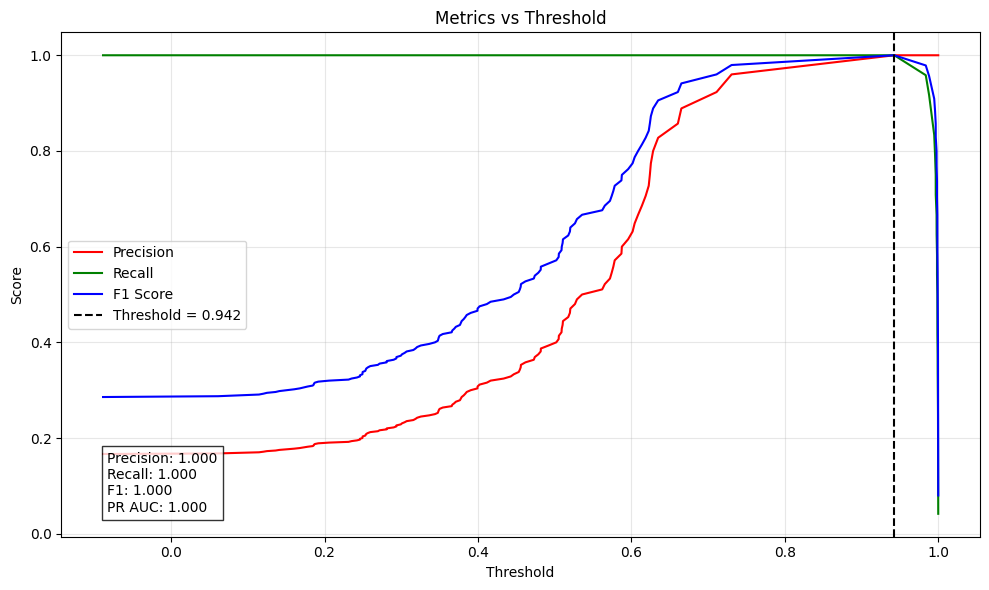

In [11]:
def visualize_threshold(similarities, true_labels, optimal_threshold, metrics):
    """
    Visualize the metrics vs threshold curve and the optimal threshold

    Args:
        similarities: Array of similarity scores
        true_labels: Array of true labels (0/1)
        optimal_threshold: The selected optimal threshold
        metrics: Dictionary of metrics at the optimal threshold
    """
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels, similarities)

    # Compute F1 scores for visualization
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Create figure with a single plot (removed the first subplot)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot precision, recall, and F1 vs threshold
    ax.plot(thresholds, precision[:-1], 'r-', label='Precision')
    ax.plot(thresholds, recall[:-1], 'g-', label='Recall')
    ax.plot(thresholds, f1_scores[:-1], 'b-', label='F1 Score')

    # Mark the optimal threshold
    ax.axvline(x=optimal_threshold, color='k', linestyle='--',
               label=f'Threshold = {optimal_threshold:.3f}')

    # Add text with metrics at optimal threshold
    text = (f"Precision: {metrics['precision']:.3f}\n"
            f"Recall: {metrics['recall']:.3f}\n"
            f"F1: {metrics['f1']:.3f}\n"
            f"PR AUC: {metrics['pr_auc']:.3f}")
    ax.text(0.05, 0.05, text, transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_title('Metrics vs Threshold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

# After finding the optimal threshold:
visualize_threshold(val_similarities, val_labels, optimal_threshold, metrics)

# 8. Evaluation on Held-out Test


- PR-AUC is preferred over ROC-AUC for imbalanced datasets
- Recall@99%Precision is a business-relevant metric that answers: "What percentage of duplicates can we catch if we only accept predictions with 99% certainty?"
- These metrics provide a threshold-independent evaluation of model performance
- Using multiple metrics gives a more complete picture of model behavior in different operating conditions

In [12]:
# In a real-world scenario, we would have a separate test set
# Here, we'll use the validation set as our "held-out" test for demonstration
test_pairs = val_pairs.copy()

# Compute similarities on test set
test_similarities, test_labels = compute_similarities(model, test_pairs, sentence_cache)

# Calculate metrics using the optimal threshold
test_predictions = (test_similarities >= optimal_threshold).astype(int)

# Count positive and negative pairs in test set
positive_pairs = sum(test_labels)
negative_pairs = len(test_labels) - positive_pairs
print(f"\nTest Set Composition:")
print(f"Positive invoice pairs: {positive_pairs}")
print(f"Negative invoice pairs: {negative_pairs}")
print(f"Total pairs: {len(test_labels)}")

# Calculate metrics
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)
test_precision_curve, test_recall_curve, _ = precision_recall_curve(test_labels, test_similarities)
test_pr_auc = auc(test_recall_curve, test_precision_curve)
test_roc_auc = roc_auc_score(test_labels, test_similarities)

# Calculate Recall at 99% Precision
precision_curve, recall_curve, thresholds_curve = precision_recall_curve(test_labels, test_similarities)
idx_at_99_precision = np.argmin(np.abs(precision_curve - 0.99))
recall_at_99_precision = recall_curve[idx_at_99_precision]

# Print test results
print("\nTest Results:")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"PR-AUC: {test_pr_auc:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")
print(f"Recall@99%Precision: {recall_at_99_precision:.4f}")

# Add prediction and similarity to test_pairs dataframe
test_pairs_with_pred = test_pairs.copy()
test_pairs_with_pred['prediction'] = test_predictions
test_pairs_with_pred['similarity'] = test_similarities

# Display 5 correctly predicted positive pairs
print("\nSample of 5 correctly predicted positive invoice pairs:")
positive_predictions = test_pairs_with_pred[(test_pairs_with_pred['prediction'] == 1) &
                                           (test_pairs_with_pred['LABEL'] == 1)]
if len(positive_predictions) >= 5:
    sample = positive_predictions.head(5)
    for _, row in sample.iterrows():
        print(f"Doc1: {row['INV1_DOC_NO']}, Doc2: {row['INV2_DOC_NO']}, "
              f"Similarity: {row['similarity']:.4f}")
else:
    print(f"Only {len(positive_predictions)} positive predictions available.")

Encoding 261 unique sentences...


  0%|          | 0/144 [00:00<?, ?it/s]


Test Set Composition:
Positive invoice pairs: 24
Negative invoice pairs: 120
Total pairs: 144

Test Results:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
PR-AUC: 1.0000
ROC-AUC: 1.0000
Recall@99%Precision: 1.0000

Sample of 5 correctly predicted positive invoice pairs:
Doc1: 3000000967, Doc2: 3000000968, Similarity: 0.9976
Doc1: 3000001035, Doc2: 3000001036, Similarity: 0.9975
Doc1: 3000000433, Doc2: 3000000434, Similarity: 0.9987
Doc1: 3000000463, Doc2: 3000000464, Similarity: 0.9986
Doc1: 3000000725, Doc2: 3000000726, Similarity: 0.9956


# 9. Create Deployment Artifacts


- The deployment script evaluates O(n²) pairs, which is feasible for batch processing but would need blocking strategies for larger datasets
- Encoding each invoice only once and then comparing embeddings is computationally efficient
- Providing similarity scores alongside binary decisions enables human review of borderline cases
- Separating the model from the threshold allows recalibration without retraining

In [8]:
predict_script = """
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import argparse
from tqdm import tqdm
import gc

def row_to_sentence(row):
    '''
    Convert a row to a sentence using a deterministic template.

    Args:
        row: DataFrame row

    Returns:
        String sentence representation
    '''
    # Handle missing values
    vendor_name = row['VENDOR_NAME'] if not pd.isna(row['VENDOR_NAME']) and row['VENDOR_NAME'] != '' else "unknown"
    vendor_id = row['VENDOR_ID'] if not pd.isna(row['VENDOR_ID']) and row['VENDOR_ID'] != '' else "unknown"

    # Format invoice date
    try:
        invoice_date = row['INVOICE_DATE'].strftime('%Y-%m-%d') if not pd.isna(row['INVOICE_DATE']) else "unknown"
    except:
        invoice_date = "unknown"

    # Format amount
    try:
        amount = f"{float(row['AMOUNT']):.2f}" if not pd.isna(row['AMOUNT']) else "unknown"
    except:
        amount = "unknown"

    currency = row['CURRENCY'] if not pd.isna(row['CURRENCY']) and row['CURRENCY'] != '' else "unknown"
    cost_center = row['COST_CENTER'] if not pd.isna(row['COST_CENTER']) and row['COST_CENTER'] != '' else "unknown"
    tax_code = row['TAX_CODE'] if not pd.isna(row['TAX_CODE']) and row['TAX_CODE'] != '' else "unknown"
    payment_terms = row['PAYMENT_TERMS'] if not pd.isna(row['PAYMENT_TERMS']) and row['PAYMENT_TERMS'] != '' else "unknown"
    purchase_order = row['PURCHASE_ORDER'] if not pd.isna(row['PURCHASE_ORDER']) and row['PURCHASE_ORDER'] != '' else "unknown"
    description = row['DESCRIPTION'] if not pd.isna(row['DESCRIPTION']) and row['DESCRIPTION'] != '' else "unknown"

    # Combine into template
    template = (
        f"Invoice from {vendor_name} ({vendor_id}) "
        f"dated {invoice_date} for {amount} {currency}. "
        f"PO: {purchase_order}. Cost centre {cost_center}. Tax {tax_code}. Terms {payment_terms}. "
        f"Description: {description}."
    )

    return template

def predict_duplicates(df, model_path, threshold_path, output_path='duplicates.csv', batch_size=250000):
    '''
    Predict duplicates in a dataframe using the trained model.

    Args:
        df: DataFrame containing invoice data
        model_path: Path to the saved model
        threshold_path: Path to the saved threshold
        output_path: Path to save the duplicates CSV
        batch_size: Number of pairs to process in each batch
    '''
    # Load model and threshold
    print(f"Loading model from {model_path}")
    model = SentenceTransformer(model_path)

    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    with open(threshold_path, 'r') as f:
        threshold = float(f.read().strip())

    print(f"Using similarity threshold: {threshold}")

    # Create sentences for all invoices
    print(f"Processing {len(df)} invoices")

    # Create a map of DOC_NO to index for faster lookups
    doc_no_to_idx = {doc_no: idx for idx, doc_no in enumerate(df['DOC_NO'])}

    # Create sentence cache
    sentence_cache = {}
    for idx, row in df.iterrows():
        sentence = row_to_sentence(row)
        sentence_cache[idx] = sentence

    # Generate candidate pairs using the same blocking strategy as in training
    print("Generating candidate pairs with blocking strategy...")

    N = len(df)
    total_possible_pairs = N * (N - 1) // 2
    print(f"Total possible pairs without blocking: {total_possible_pairs}")

    # Set for candidate pairs to avoid duplicates
    candidate_pairs = set()

    # 1. BLOCKING BY VENDOR_ID
    print("Blocking by VENDOR_ID...")
    vendor_groups = df.groupby('VENDOR_ID').indices
    for vendor_id, indices in vendor_groups.items():
        if len(indices) < 2:
            continue

        # Add all pairs within this vendor group
        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    print(f"After VENDOR_ID blocking: {len(candidate_pairs)} candidate pairs")

    # 2. BLOCKING BY VENDOR_NAME PREFIX (first 4 chars)
    print("Blocking by VENDOR_NAME prefix...")
    vendor_name_prefix_groups = {}
    for idx, vendor_name in enumerate(df['VENDOR_NAME']):
        if pd.isna(vendor_name) or vendor_name == '':
            continue

        prefix = str(vendor_name)[:4] if len(str(vendor_name)) >= 4 else str(vendor_name)
        if prefix not in vendor_name_prefix_groups:
            vendor_name_prefix_groups[prefix] = []
        vendor_name_prefix_groups[prefix].append(idx)

    for prefix, indices in vendor_name_prefix_groups.items():
        if len(indices) < 2:
            continue

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    print(f"After VENDOR_NAME prefix blocking: {len(candidate_pairs)} candidate pairs")

    # 3. BLOCKING BY PURCHASE_ORDER
    print("Blocking by PURCHASE_ORDER...")
    po_groups = df.groupby('PURCHASE_ORDER').indices
    for po, indices in po_groups.items():
        if pd.isna(po) or po == '' or len(indices) < 2:
            continue

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    print(f"After PURCHASE_ORDER blocking: {len(candidate_pairs)} candidate pairs")

    # 4. BLOCKING BY DESCRIPTION
    print("Blocking by DESCRIPTION...")
    desc_groups = df.groupby('DESCRIPTION').indices
    for desc, indices in desc_groups.items():
        if pd.isna(desc) or desc == '' or len(indices) < 2:
            continue

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    print(f"After DESCRIPTION blocking: {len(candidate_pairs)} candidate pairs")

    # 5. BLOCKING BY AMOUNT AND CURRENCY
    print("Blocking by AMOUNT and CURRENCY...")
    amount_currency_groups = df.groupby(['AMOUNT', 'CURRENCY']).indices
    for (amount, currency), indices in amount_currency_groups.items():
        if pd.isna(amount) or pd.isna(currency) or len(indices) < 2:
            continue

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                candidate_pairs.add((min(idx1, idx2), max(idx1, idx2)))

    # Convert set to list for easier processing
    candidate_pairs = list(candidate_pairs)

    print(f"Generated {len(candidate_pairs)} candidate pairs after all blocking")
    print(f"Reduction: {1 - len(candidate_pairs)/total_possible_pairs:.2%} of pairs filtered out")

    # Initialize batch processing
    print("Processing candidate pairs in batches...")
    duplicate_dfs = []
    current_batch = []

    # Process pairs in batches
    for pair_idx, (idx1, idx2) in enumerate(tqdm(candidate_pairs)):
        current_batch.append((idx1, idx2))

        # Process batch when it reaches the desired size or final batch
        if len(current_batch) >= batch_size or pair_idx == len(candidate_pairs) - 1:
            batch_result = process_candidate_batch(current_batch, df, model, device, sentence_cache, threshold)
            if not batch_result.empty:
                duplicate_dfs.append(batch_result)
            current_batch = []

            # Free memory
            gc.collect()

    # Combine all batches
    if duplicate_dfs:
        final_duplicates_df = pd.concat(duplicate_dfs, ignore_index=True)

        # Sort by similarity score
        final_duplicates_df = final_duplicates_df.sort_values('similarity', ascending=False)

        print(f"Found {len(final_duplicates_df)} potential duplicates")
        final_duplicates_df.to_csv(output_path, index=False)
        print(f"Saved results to {output_path}")
        return final_duplicates_df
    else:
        print("No duplicates found")
        # Create empty DataFrame with proper column structure
        empty_df = pd.DataFrame(columns=['similarity'] +
                               [f'INV1_{col}' for col in df.columns] +
                               [f'INV2_{col}' for col in df.columns])
        empty_df.to_csv(output_path, index=False)
        return empty_df

def process_candidate_batch(batch, df, model, device, sentence_cache, threshold):
    '''
    Process a batch of candidate pairs and return duplicates.

    Args:
        batch: List of (idx1, idx2) tuples
        df: DataFrame containing invoice data
        model: Trained SBERT model
        device: Device to run model on
        sentence_cache: Dictionary mapping indices to sentence representations
        threshold: Similarity threshold

    Returns:
        DataFrame of duplicates
    '''
    # Get sentences for encoding
    batch_indices = set()
    for idx1, idx2 in batch:
        batch_indices.add(idx1)
        batch_indices.add(idx2)

    batch_indices = list(batch_indices)
    batch_sentences = [sentence_cache[idx] for idx in batch_indices]

    # Create index mapping for this batch
    batch_idx_map = {idx: i for i, idx in enumerate(batch_indices)}

    # Encode sentences
    embeddings = model.encode(batch_sentences, convert_to_tensor=True, device=device)

    # Compute similarities and find duplicates
    duplicates = []
    for idx1, idx2 in batch:
        emb_idx1 = batch_idx_map[idx1]
        emb_idx2 = batch_idx_map[idx2]

        emb1 = embeddings[emb_idx1]
        emb2 = embeddings[emb_idx2]

        similarity = torch.dot(emb1, emb2) / (torch.norm(emb1) * torch.norm(emb2))
        similarity = similarity.item()

        if similarity >= threshold:
            record = {'similarity': similarity}

            # Add columns for first invoice with prefix INV1_
            for col in df.columns:
                record[f'INV1_{col}'] = df.iloc[idx1][col]

            # Add columns for second invoice with prefix INV2_
            for col in df.columns:
                record[f'INV2_{col}'] = df.iloc[idx2][col]

            duplicates.append(record)

    if duplicates:
        # Create dataframe from duplicates
        duplicates_df = pd.DataFrame(duplicates)

        # Reorder columns to have all INV1_ columns first, then INV2_, then similarity
        inv1_cols = [col for col in duplicates_df.columns if col.startswith('INV1_')]
        inv2_cols = [col for col in duplicates_df.columns if col.startswith('INV2_')]

        # New column order with similarity at the end
        new_col_order = inv1_cols + inv2_cols + ['similarity']

        # Reorder DataFrame columns
        duplicates_df = duplicates_df[new_col_order]

        return duplicates_df
    else:
        return pd.DataFrame()

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Predict invoice duplicates')
    parser.add_argument('--input', type=str, required=True, help='Path to input CSV file')
    parser.add_argument('--model', type=str, default='invoice_sbert', help='Path to model directory')
    parser.add_argument('--threshold', type=str, default='best_threshold.txt', help='Path to threshold file')
    parser.add_argument('--output', type=str, default='duplicates.csv', help='Path to output CSV file')
    parser.add_argument('--batch-size', type=int, default=250000, help='Batch size for processing')

    args = parser.parse_args()

    # Set random seed for reproducibility
    os.environ['PYTHONHASHSEED'] = '42'

    # Load data
    print(f"Loading data from {args.input}")
    df = pd.read_csv(args.input, dtype=str, sep=';')

    # Convert numeric and date columns
    df['AMOUNT'] = pd.to_numeric(df['AMOUNT'], errors='coerce')
    df['INVOICE_DATE'] = pd.to_datetime(df['INVOICE_DATE'], errors='coerce', format='mixed')

    # Predict duplicates
    predict_duplicates(df, args.model, args.threshold, args.output, args.batch_size)
"""


with open('/content/predict_pairs.py', 'w') as f:
    f.write(predict_script)

# Create requirements.txt for GPU
requirements = """# Core dependencies
sentence-transformers>=4.1.0
torch>=2.6.0
tqdm>=4.66.3

# Data handling
pandas>=2.1.4
numpy>=1.26.0

# Other utilities
scikit-learn>=1.3.2
"""

with open('/content/requirements.txt', 'w') as f:
    f.write(requirements)

# Create a ZIP file with all deployment artifacts
!zip -r /content/invoice_deduplication_model.zip /content/invoice_sbert /content/best_threshold.txt /content/predict_pairs.py /content/requirements.txt

print("Deployment artifacts created and zipped to /content/invoice_deduplication_model.zip")

	zip warning: name not matched: /content/invoice_sbert
	zip warning: name not matched: /content/best_threshold.txt
  adding: content/predict_pairs.py (deflated 72%)
  adding: content/requirements.txt (deflated 19%)
Deployment artifacts created and zipped to /content/invoice_deduplication_model.zip


# 10. Testing the Deployment Script


In [14]:
# Test the prediction script with a small sample
test_df = df.head(100)
test_df.to_csv('/content/test_invoices.csv', index=False)

# Test the prediction script
!python /content/predict_pairs.py --input /content/test_invoices.csv --model /content/invoice_sbert --threshold /content/best_threshold.txt --output /content/test_duplicates.csv

# Load and display results
test_duplicates = pd.read_csv('/content/test_duplicates.csv')
print("\nDetected duplicates:")
print(test_duplicates.head(10).to_string())

# Show summary of results
if not test_duplicates.empty:
    print(f"\nFound {len(test_duplicates)} potential duplicate pairs")

    # Display distribution of similarity scores
    print("\nSimilarity score distribution:")
    print(test_duplicates['similarity'].describe())
else:
    print("\nNo duplicate pairs found in the test sample")

2025-05-12 14:21:17.983691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747059678.005251   16230 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747059678.011573   16230 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading data from /content/test_invoices.csv
Loading model from /content/invoice_sbert
Using similarity threshold: 0.9424467
Processing 100 invoices
Generating candidate pairs with blocking strategy...
Total possible pairs without blocking: 4950
Blocking by VENDOR_ID...
After VENDOR_ID blocking: 128 candidate pairs
Blocking by VENDOR_NAME prefix...
After VENDOR_NAME prefix blocking: 239 candidate pairs
Blocking by PURCHASE_ORDER...
A